In [1]:
# --- Bloco 0: Importações ---
import pandas as pd
import numpy as np
import joblib # Para salvar os scalers

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn (para pré-processamento e métricas)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Optuna (para otimização de hiperparâmetros)
import optuna
import plotly.graph_objects as go
from optuna.trial import TrialState

# Outros
import math
import time
import matplotlib.pyplot as plt

# Configurações
plt.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
torch.manual_seed(42)

C:\Users\Danone\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Usando dispositivo: cpu


In [2]:
# --- Bloco 1: Definição da Arquitetura da Rede (Dinâmica) ---
# Este bloco define *como* construir a rede,
# mas ela será instanciada dinamicamente pelo Optuna.

class Net(nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(Net, self).__init__()
        
        layers = []
        
        # Camada de entrada (1 feature: Potencia_MW)
        layers.append(nn.Linear(1, n_neurons))
        layers.append(nn.ReLU())
        
        # Camadas ocultas dinâmicas
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
            layers.append(nn.ReLU())
            
        # Camada de saída (1 feature: Custo_Real)
        layers.append(nn.Linear(n_neurons, 1))
        
        # Compilar todas as camadas em um modelo sequencial
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

print("Definição da classe 'Net' concluída.")

Definição da classe 'Net' concluída.


In [3]:
# --- Bloco 2: Funções Auxiliares (Métricas e Complexidade) ---

def calculate_complexity(n_layers, n_neurons):
    """
    Calcula a métrica de complexidade customizada:
    log2(número de neurônios por camada) * número de camadas
    """
    if n_neurons == 0 or n_layers == 0:
        return 0
    return math.log2(n_neurons) * n_layers

def calculate_all_metrics(y_true, y_pred):
    """
    Calcula MSE, RMSE e MAPE.
    Espera arrays NumPy.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, rmse, mape

print("Funções auxiliares (calculate_complexity, calculate_all_metrics) prontas.")

Funções auxiliares (calculate_complexity, calculate_all_metrics) prontas.


In [4]:
# --- Bloco 3: Carregamento e Normalização dos Dados ---

# Carregar o dataset
df = pd.read_csv('usina_carvao_dataset.csv')

# Preparar dados para o scaler
X = df[['Potencia_MW']].values
y = df[['Custo_Real']].values

# Inicializar os scalers
# Usamos dois scalers separados para podermos
# salvar ambos e usá-los no notebook MILP.
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# "Aprender" a escala dos dados e transformá-los
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Salvar os scalers para uso futuro!
joblib.dump(x_scaler, 'x_scaler.joblib')
joblib.dump(y_scaler, 'y_scaler.joblib')

print("Dados carregados e normalizados.")
print(f"Formato de X (Potência): {X_scaled.shape}")
print(f"Formato de y (Custo): {y_scaled.shape}")
print("\nScalers 'x_scaler.joblib' e 'y_scaler.joblib' salvos.")

Dados carregados e normalizados.
Formato de X (Potência): (5000, 1)
Formato de y (Custo): (5000, 1)

Scalers 'x_scaler.joblib' e 'y_scaler.joblib' salvos.


In [5]:
# --- Bloco 4: Separação Aleatória e DataLoaders ---
# Este bloco mistura os dados (shuffle=True) e os separa
# em conjuntos de treino e validação.

# Separar em treino (80%) e validação (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Converter dados NumPy para Tensores do PyTorch
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)

# Criar DataLoaders para treinamento em lote (batch)
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dados separados: {len(X_train_t)} amostras de treino, {len(X_val_t)} amostras de validação.")

Dados separados: 4000 amostras de treino, 1000 amostras de validação.


In [6]:
# --- Bloco 5: Definição da Função 'objective' do Optuna ---
# Este é o coração do notebook. Esta função será chamada
# dezenas de vezes pelo Optuna.

# Parâmetros do Treinamento
N_EPOCHS = 300       # Número de épocas que você definiu
EARLY_STOPPING_PATIENCE = 30 # Paciência que você pediu

def objective(trial):
    # --- 1. Sugerir Hiperparâmetros ---
    # Número de camadas (1 a 3)
    n_layers = trial.suggest_int('n_layers', 1, 3)
    # Número de neurônios (3 a 20)
    n_neurons = trial.suggest_int('n_neurons', 3, 20)
    # Taxa de aprendizado
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    
    # --- 2. Calcular Complexidade e Armazenar ---
    complexity = calculate_complexity(n_layers, n_neurons)
    trial.set_user_attr('complexity', complexity)

    # --- 3. Construir Modelo e Otimizador ---
    model = Net(n_layers, n_neurons).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss() # Usamos MSE para o loss

    # --- 4. Loop de Treinamento com Early Stopping & Pruning ---
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(N_EPOCHS):
        # Treinamento
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        # Validação
        model.eval()
        current_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                current_val_loss += loss.item() * X_batch.size(0)
        
        current_val_loss /= len(val_loader.dataset)
        
        # --- 5. Lógica de Pruning (pelo Optuna) ---
        trial.report(current_val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        # --- 6. Lógica de Early Stopping ---
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            # print(f"Trial {trial.number} parou cedo no epoch {epoch}")
            break
            
    # --- 7. Retornar Métrica de Qualidade (RMSE) ---
    # Optuna minimiza o valor retornado.
    # Usamos o RMSE (raiz do MSE) como métrica de seleção.
    final_rmse = math.sqrt(best_val_loss)
    trial.set_user_attr('val_rmse', final_rmse)
    
    return final_rmse

print("Função 'objective' do Optuna definida.")

Função 'objective' do Optuna definida.


In [7]:
# --- Bloco 6: Execução do Estudo Optuna ---

print("--- Iniciando Estudo Optuna ---")
# Habilitar o Pruner (Poda) para cortar trials ruins
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)

study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("\n--- Estudo Optuna Concluído ---")
print(f"Melhor trial: {study.best_trial.number}")
print(f"  Melhor RMSE de Validação: {study.best_value:.6f}")
print("  Melhores Hiperparâmetros:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")
    
complexity = study.best_trial.user_attrs['complexity']
print(f"  Complexidade do Melhor Modelo: {complexity:.2f}")

[I 2025-10-27 20:42:25,905] A new study created in memory with name: no-name-a70f6fe3-6b7c-4e02-8597-423959d9de34


--- Iniciando Estudo Optuna ---


Best trial: 0. Best value: 0.00591231:   1%|          | 1/100 [00:11<19:46, 11.99s/it]

[I 2025-10-27 20:42:37,893] Trial 0 finished with value: 0.0059123095293846855 and parameters: {'n_layers': 3, 'n_neurons': 5, 'lr': 0.0025447446274749685}. Best is trial 0 with value: 0.0059123095293846855.


Best trial: 0. Best value: 0.00591231:   2%|▏         | 2/100 [00:24<19:49, 12.14s/it]

[I 2025-10-27 20:42:50,134] Trial 1 finished with value: 0.005914226938405474 and parameters: {'n_layers': 1, 'n_neurons': 13, 'lr': 0.000834964377711192}. Best is trial 0 with value: 0.0059123095293846855.


Best trial: 0. Best value: 0.00591231:   3%|▎         | 3/100 [00:30<15:11,  9.39s/it]

[I 2025-10-27 20:42:56,261] Trial 2 finished with value: 0.019313381988175015 and parameters: {'n_layers': 3, 'n_neurons': 3, 'lr': 0.006509524584210068}. Best is trial 0 with value: 0.0059123095293846855.


Best trial: 3. Best value: 0.00242113:   4%|▍         | 4/100 [00:49<20:53, 13.06s/it]

[I 2025-10-27 20:43:14,935] Trial 3 finished with value: 0.0024211294346731323 and parameters: {'n_layers': 1, 'n_neurons': 6, 'lr': 0.0004433217561365005}. Best is trial 3 with value: 0.0024211294346731323.


Best trial: 3. Best value: 0.00242113:   5%|▌         | 5/100 [01:00<19:47, 12.50s/it]

[I 2025-10-27 20:43:26,460] Trial 4 finished with value: 0.02377463309711461 and parameters: {'n_layers': 2, 'n_neurons': 3, 'lr': 0.0007443688519415774}. Best is trial 3 with value: 0.0024211294346731323.


Best trial: 3. Best value: 0.00242113:   6%|▌         | 6/100 [01:07<16:39, 10.63s/it]

[I 2025-10-27 20:43:33,458] Trial 5 finished with value: 0.005921723775541623 and parameters: {'n_layers': 2, 'n_neurons': 11, 'lr': 0.006805903764448262}. Best is trial 3 with value: 0.0024211294346731323.


Best trial: 6. Best value: 0.00105753:   7%|▋         | 7/100 [01:20<17:45, 11.46s/it]

[I 2025-10-27 20:43:46,624] Trial 6 finished with value: 0.0010575340165803237 and parameters: {'n_layers': 3, 'n_neurons': 7, 'lr': 0.04811657052028099}. Best is trial 6 with value: 0.0010575340165803237.


Best trial: 6. Best value: 0.00105753:   8%|▊         | 8/100 [01:27<15:21, 10.02s/it]

[I 2025-10-27 20:43:53,558] Trial 7 finished with value: 0.0023237288057810683 and parameters: {'n_layers': 2, 'n_neurons': 13, 'lr': 0.026900497029450646}. Best is trial 6 with value: 0.0010575340165803237.


Best trial: 6. Best value: 0.00105753:   9%|▉         | 9/100 [01:28<10:52,  7.17s/it]

[I 2025-10-27 20:43:54,479] Trial 8 pruned. 


Best trial: 9. Best value: 0.000455122:  10%|█         | 10/100 [02:00<22:21, 14.91s/it]

[I 2025-10-27 20:44:26,696] Trial 9 finished with value: 0.0004551216586447284 and parameters: {'n_layers': 3, 'n_neurons': 17, 'lr': 0.0003460527413747994}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  11%|█         | 11/100 [02:01<15:51, 10.69s/it]

[I 2025-10-27 20:44:27,832] Trial 10 pruned. 


Best trial: 9. Best value: 0.000455122:  12%|█▏        | 12/100 [02:07<13:27,  9.18s/it]

[I 2025-10-27 20:44:33,557] Trial 11 finished with value: 0.0008269128667118902 and parameters: {'n_layers': 3, 'n_neurons': 20, 'lr': 0.07499486770779708}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  13%|█▎        | 13/100 [02:08<09:47,  6.75s/it]

[I 2025-10-27 20:44:34,717] Trial 12 pruned. 


Best trial: 9. Best value: 0.000455122:  14%|█▍        | 14/100 [02:09<07:14,  5.06s/it]

[I 2025-10-27 20:44:35,857] Trial 13 pruned. 


Best trial: 9. Best value: 0.000455122:  15%|█▌        | 15/100 [02:28<12:53,  9.10s/it]

[I 2025-10-27 20:44:54,321] Trial 14 finished with value: 0.0013536682109502524 and parameters: {'n_layers': 2, 'n_neurons': 16, 'lr': 0.0021103735622438023}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  16%|█▌        | 16/100 [02:29<09:19,  6.66s/it]

[I 2025-10-27 20:44:55,313] Trial 15 pruned. 


Best trial: 9. Best value: 0.000455122:  17%|█▋        | 17/100 [02:35<08:53,  6.43s/it]

[I 2025-10-27 20:45:01,197] Trial 16 finished with value: 0.0026034258363652023 and parameters: {'n_layers': 3, 'n_neurons': 15, 'lr': 0.014749737315045358}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  18%|█▊        | 18/100 [02:36<06:37,  4.85s/it]

[I 2025-10-27 20:45:02,364] Trial 17 pruned. 


Best trial: 9. Best value: 0.000455122:  19%|█▉        | 19/100 [02:37<05:02,  3.73s/it]

[I 2025-10-27 20:45:03,505] Trial 18 pruned. 


Best trial: 9. Best value: 0.000455122:  20%|██        | 20/100 [02:43<05:56,  4.46s/it]

[I 2025-10-27 20:45:09,646] Trial 19 finished with value: 0.001318964620577679 and parameters: {'n_layers': 2, 'n_neurons': 20, 'lr': 0.0923262551103442}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  21%|██        | 21/100 [02:45<04:36,  3.50s/it]

[I 2025-10-27 20:45:10,920] Trial 20 pruned. 


Best trial: 9. Best value: 0.000455122:  22%|██▏       | 22/100 [02:46<03:39,  2.81s/it]

[I 2025-10-27 20:45:12,122] Trial 21 pruned. 


Best trial: 9. Best value: 0.000455122:  23%|██▎       | 23/100 [03:00<07:53,  6.14s/it]

[I 2025-10-27 20:45:26,037] Trial 22 finished with value: 0.0008750453516791834 and parameters: {'n_layers': 3, 'n_neurons': 8, 'lr': 0.03477284036919095}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  24%|██▍       | 24/100 [03:07<08:18,  6.55s/it]

[I 2025-10-27 20:45:33,546] Trial 23 finished with value: 0.0009870734585822264 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.023466595318818114}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  25%|██▌       | 25/100 [03:08<06:09,  4.92s/it]

[I 2025-10-27 20:45:34,672] Trial 24 pruned. 


Best trial: 9. Best value: 0.000455122:  26%|██▌       | 26/100 [03:21<09:00,  7.31s/it]

[I 2025-10-27 20:45:47,544] Trial 25 finished with value: 0.0011693311657128443 and parameters: {'n_layers': 3, 'n_neurons': 16, 'lr': 0.01850864744576365}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  27%|██▋       | 27/100 [03:22<06:38,  5.46s/it]

[I 2025-10-27 20:45:48,678] Trial 26 pruned. 


Best trial: 9. Best value: 0.000455122:  28%|██▊       | 28/100 [03:23<04:57,  4.13s/it]

[I 2025-10-27 20:45:49,698] Trial 27 pruned. 


Best trial: 9. Best value: 0.000455122:  29%|██▉       | 29/100 [03:30<05:55,  5.00s/it]

[I 2025-10-27 20:45:56,754] Trial 28 finished with value: 0.000742483756405828 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.03182508499422029}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  30%|███       | 30/100 [03:38<06:47,  5.83s/it]

[I 2025-10-27 20:46:04,501] Trial 29 finished with value: 0.0014587180788610166 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.003049334055895675}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  31%|███       | 31/100 [03:49<08:23,  7.30s/it]

[I 2025-10-27 20:46:15,222] Trial 30 finished with value: 0.0013296168470503698 and parameters: {'n_layers': 3, 'n_neurons': 20, 'lr': 0.011182717455478799}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  32%|███▏      | 32/100 [04:04<10:48,  9.54s/it]

[I 2025-10-27 20:46:30,004] Trial 31 finished with value: 0.0006354084887474874 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.03200771959475752}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  33%|███▎      | 33/100 [04:07<08:40,  7.77s/it]

[I 2025-10-27 20:46:33,624] Trial 32 finished with value: 0.0010997577535511826 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.0792209346415263}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  34%|███▍      | 34/100 [04:08<06:21,  5.77s/it]

[I 2025-10-27 20:46:34,749] Trial 33 pruned. 


Best trial: 9. Best value: 0.000455122:  35%|███▌      | 35/100 [04:14<06:22,  5.89s/it]

[I 2025-10-27 20:46:40,905] Trial 34 finished with value: 0.0012252604228566793 and parameters: {'n_layers': 3, 'n_neurons': 19, 'lr': 0.030375917526308097}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  36%|███▌      | 36/100 [04:26<07:58,  7.48s/it]

[I 2025-10-27 20:46:52,088] Trial 35 finished with value: 0.0009476128259229865 and parameters: {'n_layers': 3, 'n_neurons': 17, 'lr': 0.004742938373067632}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  37%|███▋      | 37/100 [04:27<05:46,  5.49s/it]

[I 2025-10-27 20:46:52,957] Trial 36 pruned. 


Best trial: 9. Best value: 0.000455122:  38%|███▊      | 38/100 [04:41<08:31,  8.25s/it]

[I 2025-10-27 20:47:07,634] Trial 37 finished with value: 0.0007672370152624894 and parameters: {'n_layers': 3, 'n_neurons': 19, 'lr': 0.008111927987921833}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  39%|███▉      | 39/100 [04:56<10:14, 10.08s/it]

[I 2025-10-27 20:47:21,974] Trial 38 finished with value: 0.0008087160989360509 and parameters: {'n_layers': 2, 'n_neurons': 14, 'lr': 0.008164828229766462}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  40%|████      | 40/100 [04:57<07:24,  7.41s/it]

[I 2025-10-27 20:47:23,149] Trial 39 pruned. 


Best trial: 9. Best value: 0.000455122:  41%|████      | 41/100 [04:58<05:21,  5.44s/it]

[I 2025-10-27 20:47:24,017] Trial 40 pruned. 


Best trial: 9. Best value: 0.000455122:  42%|████▏     | 42/100 [04:59<03:58,  4.12s/it]

[I 2025-10-27 20:47:25,040] Trial 41 pruned. 


Best trial: 9. Best value: 0.000455122:  43%|████▎     | 43/100 [05:00<03:01,  3.19s/it]

[I 2025-10-27 20:47:26,051] Trial 42 pruned. 


Best trial: 9. Best value: 0.000455122:  44%|████▍     | 44/100 [05:01<02:19,  2.49s/it]

[I 2025-10-27 20:47:26,910] Trial 43 pruned. 


Best trial: 9. Best value: 0.000455122:  45%|████▌     | 45/100 [05:12<04:50,  5.28s/it]

[I 2025-10-27 20:47:38,702] Trial 44 finished with value: 0.0006560198450886903 and parameters: {'n_layers': 3, 'n_neurons': 13, 'lr': 0.021596957054496404}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  46%|████▌     | 46/100 [05:14<03:48,  4.24s/it]

[I 2025-10-27 20:47:40,507] Trial 45 pruned. 


Best trial: 9. Best value: 0.000455122:  47%|████▋     | 47/100 [05:19<03:48,  4.30s/it]

[I 2025-10-27 20:47:44,965] Trial 46 pruned. 


Best trial: 9. Best value: 0.000455122:  48%|████▊     | 48/100 [05:26<04:26,  5.12s/it]

[I 2025-10-27 20:47:51,998] Trial 47 finished with value: 0.0007257002864258238 and parameters: {'n_layers': 3, 'n_neurons': 19, 'lr': 0.051924499468750406}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  49%|████▉     | 49/100 [05:34<05:12,  6.13s/it]

[I 2025-10-27 20:48:00,464] Trial 48 finished with value: 0.0008966753569337781 and parameters: {'n_layers': 3, 'n_neurons': 16, 'lr': 0.060241145909744775}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  50%|█████     | 50/100 [05:35<03:53,  4.67s/it]

[I 2025-10-27 20:48:01,742] Trial 49 pruned. 


Best trial: 9. Best value: 0.000455122:  51%|█████     | 51/100 [05:41<04:05,  5.01s/it]

[I 2025-10-27 20:48:07,543] Trial 50 finished with value: 0.0009784215762777384 and parameters: {'n_layers': 3, 'n_neurons': 17, 'lr': 0.04937477160152213}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  52%|█████▏    | 52/100 [05:43<03:08,  3.92s/it]

[I 2025-10-27 20:48:08,926] Trial 51 pruned. 


Best trial: 9. Best value: 0.000455122:  53%|█████▎    | 53/100 [05:53<04:31,  5.77s/it]

[I 2025-10-27 20:48:19,005] Trial 52 finished with value: 0.0005576388188283228 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.021830241090909853}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  54%|█████▍    | 54/100 [06:02<05:13,  6.82s/it]

[I 2025-10-27 20:48:28,279] Trial 53 finished with value: 0.001128438134534997 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.020452369661513335}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 9. Best value: 0.000455122:  55%|█████▌    | 55/100 [06:11<05:35,  7.45s/it]

[I 2025-10-27 20:48:37,203] Trial 54 finished with value: 0.0008063456341246092 and parameters: {'n_layers': 3, 'n_neurons': 20, 'lr': 0.035112213512713424}. Best is trial 9 with value: 0.0004551216586447284.


Best trial: 55. Best value: 0.000428135:  56%|█████▌    | 56/100 [06:19<05:39,  7.72s/it]

[I 2025-10-27 20:48:45,549] Trial 55 finished with value: 0.00042813510634882195 and parameters: {'n_layers': 3, 'n_neurons': 17, 'lr': 0.013262461679696263}. Best is trial 55 with value: 0.00042813510634882195.


Best trial: 55. Best value: 0.000428135:  57%|█████▋    | 57/100 [06:21<04:13,  5.90s/it]

[I 2025-10-27 20:48:47,217] Trial 56 pruned. 


Best trial: 55. Best value: 0.000428135:  58%|█████▊    | 58/100 [06:22<03:08,  4.48s/it]

[I 2025-10-27 20:48:48,364] Trial 57 pruned. 


Best trial: 55. Best value: 0.000428135:  59%|█████▉    | 59/100 [06:23<02:22,  3.48s/it]

[I 2025-10-27 20:48:49,511] Trial 58 pruned. 


Best trial: 55. Best value: 0.000428135:  60%|██████    | 60/100 [06:28<02:36,  3.92s/it]

[I 2025-10-27 20:48:54,467] Trial 59 finished with value: 0.0010778985625432083 and parameters: {'n_layers': 3, 'n_neurons': 15, 'lr': 0.02293189575835585}. Best is trial 55 with value: 0.00042813510634882195.


Best trial: 55. Best value: 0.000428135:  61%|██████    | 61/100 [06:38<03:42,  5.69s/it]

[I 2025-10-27 20:49:04,297] Trial 60 finished with value: 0.0011258334117925687 and parameters: {'n_layers': 3, 'n_neurons': 17, 'lr': 0.06265080006476163}. Best is trial 55 with value: 0.00042813510634882195.


Best trial: 55. Best value: 0.000428135:  62%|██████▏   | 62/100 [06:44<03:42,  5.86s/it]

[I 2025-10-27 20:49:10,546] Trial 61 finished with value: 0.0007103047987614784 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.041686203747225176}. Best is trial 55 with value: 0.00042813510634882195.


Best trial: 55. Best value: 0.000428135:  63%|██████▎   | 63/100 [06:56<04:39,  7.56s/it]

[I 2025-10-27 20:49:22,064] Trial 62 finished with value: 0.0010188205154826706 and parameters: {'n_layers': 3, 'n_neurons': 19, 'lr': 0.0409186908851011}. Best is trial 55 with value: 0.00042813510634882195.


Best trial: 55. Best value: 0.000428135:  64%|██████▍   | 64/100 [07:02<04:24,  7.33s/it]

[I 2025-10-27 20:49:28,874] Trial 63 finished with value: 0.0005679388933205539 and parameters: {'n_layers': 3, 'n_neurons': 20, 'lr': 0.026373725725063985}. Best is trial 55 with value: 0.00042813510634882195.


Best trial: 55. Best value: 0.000428135:  65%|██████▌   | 65/100 [07:14<05:02,  8.63s/it]

[I 2025-10-27 20:49:40,539] Trial 64 finished with value: 0.0005975704915267815 and parameters: {'n_layers': 3, 'n_neurons': 20, 'lr': 0.018074847311653028}. Best is trial 55 with value: 0.00042813510634882195.


Best trial: 55. Best value: 0.000428135:  66%|██████▌   | 66/100 [07:25<05:15,  9.29s/it]

[I 2025-10-27 20:49:51,375] Trial 65 finished with value: 0.0006130762834927361 and parameters: {'n_layers': 3, 'n_neurons': 20, 'lr': 0.014037830444842792}. Best is trial 55 with value: 0.00042813510634882195.


Best trial: 55. Best value: 0.000428135:  67%|██████▋   | 67/100 [07:30<04:28,  8.15s/it]

[I 2025-10-27 20:49:56,842] Trial 66 finished with value: 0.0008706779951170603 and parameters: {'n_layers': 3, 'n_neurons': 20, 'lr': 0.013659815638019344}. Best is trial 55 with value: 0.00042813510634882195.


Best trial: 67. Best value: 0.000387631:  68%|██████▊   | 68/100 [07:37<04:09,  7.79s/it]

[I 2025-10-27 20:50:03,797] Trial 67 finished with value: 0.00038763122976627284 and parameters: {'n_layers': 3, 'n_neurons': 20, 'lr': 0.016958810881878037}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  69%|██████▉   | 69/100 [07:42<03:30,  6.79s/it]

[I 2025-10-27 20:50:08,268] Trial 68 finished with value: 0.0006689471918995175 and parameters: {'n_layers': 3, 'n_neurons': 20, 'lr': 0.009243439858724384}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  70%|███████   | 70/100 [07:50<03:34,  7.15s/it]

[I 2025-10-27 20:50:16,235] Trial 69 finished with value: 0.0009219266564528417 and parameters: {'n_layers': 3, 'n_neurons': 20, 'lr': 0.0054725887117310565}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  71%|███████   | 71/100 [08:01<03:59,  8.28s/it]

[I 2025-10-27 20:50:27,145] Trial 70 finished with value: 0.0009725192600935562 and parameters: {'n_layers': 3, 'n_neurons': 20, 'lr': 0.00364186860188552}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  72%|███████▏  | 72/100 [08:12<04:16,  9.17s/it]

[I 2025-10-27 20:50:38,396] Trial 71 finished with value: 0.0005984788810612437 and parameters: {'n_layers': 3, 'n_neurons': 19, 'lr': 0.017642863774384787}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  73%|███████▎  | 73/100 [08:13<03:02,  6.77s/it]

[I 2025-10-27 20:50:39,555] Trial 72 pruned. 


Best trial: 67. Best value: 0.000387631:  74%|███████▍  | 74/100 [08:17<02:31,  5.83s/it]

[I 2025-10-27 20:50:43,215] Trial 73 pruned. 


Best trial: 67. Best value: 0.000387631:  75%|███████▌  | 75/100 [08:21<02:17,  5.49s/it]

[I 2025-10-27 20:50:47,890] Trial 74 finished with value: 0.000734554179834943 and parameters: {'n_layers': 3, 'n_neurons': 20, 'lr': 0.018690136459254877}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  76%|███████▌  | 76/100 [08:38<03:33,  8.88s/it]

[I 2025-10-27 20:51:04,687] Trial 75 finished with value: 0.0005817301664101481 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.012799091000940054}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  77%|███████▋  | 77/100 [08:55<04:15, 11.10s/it]

[I 2025-10-27 20:51:20,954] Trial 76 finished with value: 0.0006235333173220572 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.026854553898172717}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  78%|███████▊  | 78/100 [09:02<03:36,  9.86s/it]

[I 2025-10-27 20:51:27,942] Trial 77 finished with value: 0.0009097642844330644 and parameters: {'n_layers': 3, 'n_neurons': 19, 'lr': 0.018250497428824865}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  79%|███████▉  | 79/100 [09:03<02:32,  7.26s/it]

[I 2025-10-27 20:51:29,120] Trial 78 pruned. 


Best trial: 67. Best value: 0.000387631:  80%|████████  | 80/100 [09:12<02:34,  7.74s/it]

[I 2025-10-27 20:51:37,991] Trial 79 finished with value: 0.0004958977523375031 and parameters: {'n_layers': 3, 'n_neurons': 17, 'lr': 0.011066967651612036}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  81%|████████  | 81/100 [09:13<01:49,  5.76s/it]

[I 2025-10-27 20:51:39,131] Trial 80 pruned. 


Best trial: 67. Best value: 0.000387631:  82%|████████▏ | 82/100 [09:14<01:19,  4.41s/it]

[I 2025-10-27 20:51:40,393] Trial 81 pruned. 


Best trial: 67. Best value: 0.000387631:  83%|████████▎ | 83/100 [09:20<01:21,  4.81s/it]

[I 2025-10-27 20:51:46,124] Trial 82 finished with value: 0.0007445489761620633 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.00932031767411855}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  84%|████████▍ | 84/100 [09:27<01:30,  5.67s/it]

[I 2025-10-27 20:51:53,792] Trial 83 finished with value: 0.0007910685533380678 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.016110072621105538}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  85%|████████▌ | 85/100 [09:47<02:26,  9.74s/it]

[I 2025-10-27 20:52:13,037] Trial 84 finished with value: 0.0006094123240896733 and parameters: {'n_layers': 3, 'n_neurons': 19, 'lr': 0.011777685771090531}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  86%|████████▌ | 86/100 [09:48<01:40,  7.17s/it]

[I 2025-10-27 20:52:14,198] Trial 85 pruned. 


Best trial: 67. Best value: 0.000387631:  87%|████████▋ | 87/100 [09:57<01:40,  7.70s/it]

[I 2025-10-27 20:52:23,152] Trial 86 finished with value: 0.0006004285723197464 and parameters: {'n_layers': 3, 'n_neurons': 19, 'lr': 0.01969566752858649}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  88%|████████▊ | 88/100 [09:58<01:08,  5.73s/it]

[I 2025-10-27 20:52:24,283] Trial 87 pruned. 


Best trial: 67. Best value: 0.000387631:  89%|████████▉ | 89/100 [10:04<01:04,  5.83s/it]

[I 2025-10-27 20:52:30,347] Trial 88 finished with value: 0.0007622875599541451 and parameters: {'n_layers': 3, 'n_neurons': 20, 'lr': 0.025694287659174017}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  90%|█████████ | 90/100 [10:13<01:07,  6.71s/it]

[I 2025-10-27 20:52:39,123] Trial 89 finished with value: 0.00047944029887569386 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.01711329753876703}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  91%|█████████ | 91/100 [10:14<00:45,  5.05s/it]

[I 2025-10-27 20:52:40,278] Trial 90 pruned. 


Best trial: 67. Best value: 0.000387631:  92%|█████████▏| 92/100 [10:21<00:46,  5.75s/it]

[I 2025-10-27 20:52:47,677] Trial 91 finished with value: 0.00045771597424998015 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.017686613804013096}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  93%|█████████▎| 93/100 [10:31<00:47,  6.81s/it]

[I 2025-10-27 20:52:56,939] Trial 92 finished with value: 0.0008349633099728091 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.012457213948617938}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  94%|█████████▍| 94/100 [10:32<00:30,  5.11s/it]

[I 2025-10-27 20:52:58,101] Trial 93 pruned. 


Best trial: 67. Best value: 0.000387631:  95%|█████████▌| 95/100 [10:47<00:40,  8.18s/it]

[I 2025-10-27 20:53:13,439] Trial 94 finished with value: 0.0005248124831390946 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.021885890720488594}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  96%|█████████▌| 96/100 [10:55<00:33,  8.25s/it]

[I 2025-10-27 20:53:21,859] Trial 95 finished with value: 0.0008607224886646825 and parameters: {'n_layers': 3, 'n_neurons': 18, 'lr': 0.034345602123280174}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631:  97%|█████████▋| 97/100 [10:57<00:18,  6.12s/it]

[I 2025-10-27 20:53:23,017] Trial 96 pruned. 


Best trial: 67. Best value: 0.000387631:  98%|█████████▊| 98/100 [10:58<00:09,  4.64s/it]

[I 2025-10-27 20:53:24,209] Trial 97 pruned. 


Best trial: 67. Best value: 0.000387631:  99%|█████████▉| 99/100 [11:07<00:06,  6.06s/it]

[I 2025-10-27 20:53:33,589] Trial 98 finished with value: 0.0007038081176793452 and parameters: {'n_layers': 3, 'n_neurons': 17, 'lr': 0.029439475650915325}. Best is trial 67 with value: 0.00038763122976627284.


Best trial: 67. Best value: 0.000387631: 100%|██████████| 100/100 [11:08<00:00,  6.69s/it]

[I 2025-10-27 20:53:34,752] Trial 99 pruned. 

--- Estudo Optuna Concluído ---
Melhor trial: 67
  Melhor RMSE de Validação: 0.000388
  Melhores Hiperparâmetros:
    n_layers: 3
    n_neurons: 20
    lr: 0.016958810881878037
  Complexidade do Melhor Modelo: 12.97


In [8]:
# --- Bloco 7: Gráficos Elaborados do Optuna ---

print("Gerando gráficos do Optuna...")

# Gráfico 1: Histórico de Otimização (RMSE vs. Trial)
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.show()

# Gráfico 2: Importância dos Hiperparâmetros
fig2 = optuna.visualization.plot_param_importances(study)
fig2.show()

# Gráfico 3: Gráfico Customizado (Qualidade vs. Complexidade)
# Este é o gráfico que você pediu
trials = [t for t in study.trials if t.state == TrialState.COMPLETE]
complexities = [t.user_attrs['complexity'] for t in trials]
val_rmses = [t.value for t in trials]
trial_numbers = [t.number for t in trials]

fig3 = go.Figure(data=go.Scatter(
    x=complexities,
    y=val_rmses,
    mode='markers',
    text=[f'Trial: {n}<br>RMSE: {r:.4f}<br>Complex: {c:.2f}' 
          for n, r, c in zip(trial_numbers, val_rmses, complexities)],
    marker=dict(
        color=val_rmses,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='RMSE de Validação')
    )
))
fig3.update_layout(
    title='Trade-off: Qualidade (RMSE) vs. Complexidade do Modelo',
    xaxis_title='Complexidade (log2(neurônios) * camadas)',
    yaxis_title='RMSE de Validação (Normalizado)',
    hovermode='closest'
)
fig3.show()

Gerando gráficos do Optuna...


In [ ]:
# --- Bloco 8: Treinamento Final da Rede "Campeã" ---
# Agora, pegamos os melhores hiperparâmetros e treinamos
# um modelo final do zero, salvando o histórico de loss.

print("--- Treinando a Rede 'Campeã' Final ---")

'''
best_params = study.best_params
BASE_N_LAYERS = best_params['n_layers']
BASE_N_NEURONS = best_params['n_neurons']
BASE_LR = best_params['lr']
#'''

# {'n_layers': 3, 'n_neurons': 20, 'lr': 0.016958810881878037}

#'''
BASE_N_LAYERS = 2
BASE_N_NEURONS = 13
BASE_LR = 0.008164828229766462
N_EPOCHS = 10
#'''

# Parâmetros da rede
final_model = Net(
    n_layers=BASE_N_LAYERS,
    n_neurons=BASE_N_NEURONS
).to(device)
final_lr = BASE_LR


optimizer = optim.Adam(final_model.parameters(), lr=final_lr)
criterion = nn.MSELoss()

# Listas para salvar o histórico de loss
train_losses = []
val_losses = []

# Usar os mesmos parâmetros do Optuna
best_val_loss = float('inf')
patience_counter = 0

start_time = time.time()
for epoch in range(N_EPOCHS):
    # Treinamento
    final_model.train()
    current_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item() * X_batch.size(0)
    
    train_losses.append(current_train_loss / len(train_loader.dataset))
    
    # Validação
    final_model.eval()
    current_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = final_model(X_batch)
            loss = criterion(outputs, y_batch)
            current_val_loss += loss.item() * X_batch.size(0)
            
    current_val_loss /= len(val_loader.dataset)
    val_losses.append(current_val_loss)

    # Lógica de Early Stopping
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0
        # Salvar o melhor modelo
        torch.save(final_model.state_dict(), 'model_10_epochs.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Treinamento final parou cedo no epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{N_EPOCHS}], Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

end_time = time.time()
print(f"Treinamento final concluído em {end_time - start_time:.2f}s")
print("Modelo 'model_10_epochs.pth' salvo.")

--- Treinando a Rede 'Campeã' Final ---
Treinamento final concluído em 1.11s
Modelo 'model_10_epochs.pth' salvo.


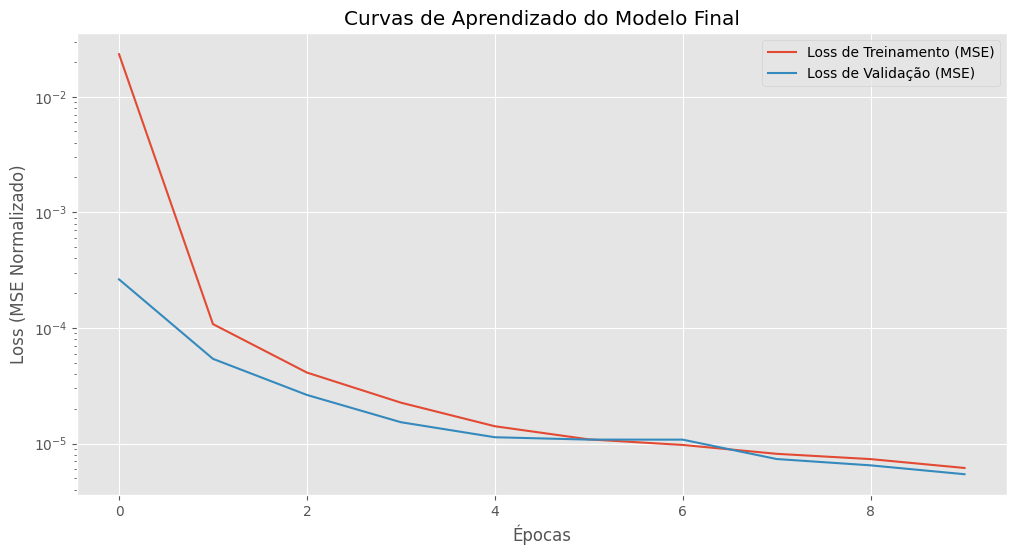

In [35]:
# --- Bloco 9: Gráfico de Treinamento (Loss vs. Epoch) ---

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Loss de Treinamento (MSE)')
plt.plot(val_losses, label='Loss de Validação (MSE)')
plt.title('Curvas de Aprendizado do Modelo Final')
#plt.ylim(0,0.0005)
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE Normalizado)')
plt.yscale('log') # Usar escala logarítmica é quase obrigatório aqui
plt.legend()
plt.show()

--- Avaliação Final do Modelo ---

Métricas Finais (em escala real de R$):
  MSE:  1,758.93
  RMSE: 41.94
  MAPE: 0.0036 %


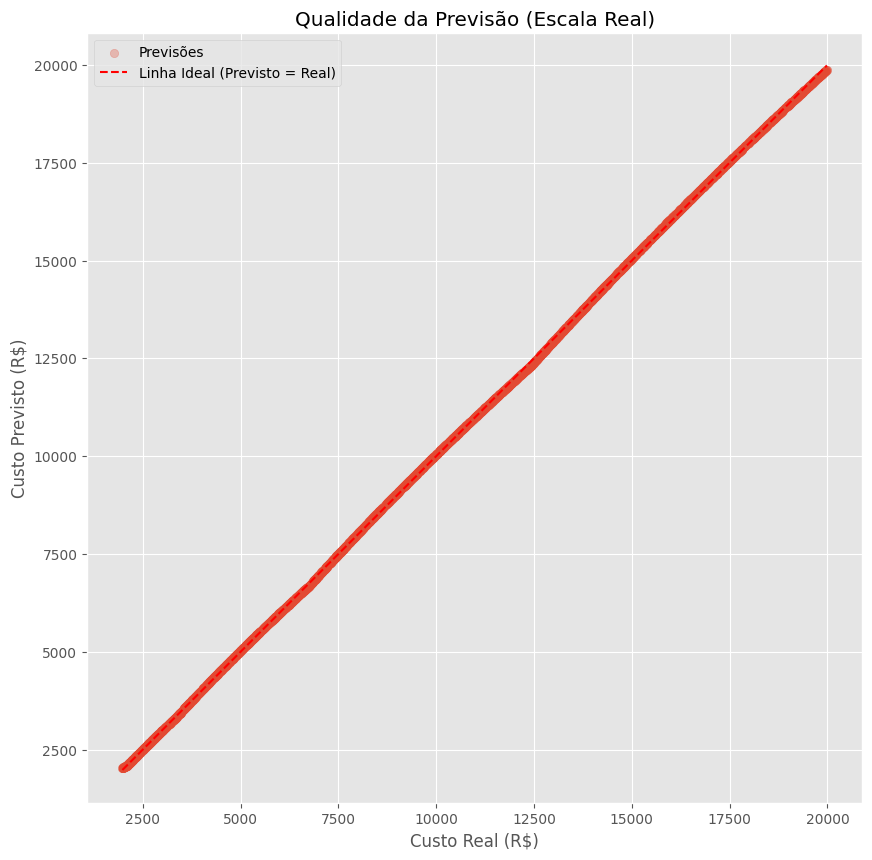

In [36]:
# --- Bloco 10: Avaliação Final (Métricas nos Dados Reais) ---

print("--- Avaliação Final do Modelo ---")

# Carregar o melhor modelo salvo
final_model.load_state_dict(torch.load('model_10_epochs.pth'))
final_model.eval()

# Passar TODOS os dados (X_scaled) pelo modelo
with torch.no_grad():
    y_pred_scaled_t = final_model(torch.tensor(X_scaled, dtype=torch.float32).to(device))

# Mover para CPU e converter para NumPy
y_pred_scaled = y_pred_scaled_t.cpu().numpy()

# --- IMPORTANTE: Reverter a Normalização ---
# Agora avaliamos na escala de R$ e MW reais
y_true_real = y_scaler.inverse_transform(y_scaled)
y_pred_real = y_scaler.inverse_transform(y_pred_scaled)
x_real = x_scaler.inverse_transform(X_scaled)

# Calcular métricas finais
mse, rmse, mape = calculate_all_metrics(y_true_real, y_pred_real)

print("\nMétricas Finais (em escala real de R$):")
print(f"  MSE:  {mse:,.2f}")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAPE: {mape:.4f} %")

# --- Gráfico Final: Real vs. Previsto ---
plt.figure(figsize=(10, 10))
plt.scatter(y_true_real, y_pred_real, alpha=0.3, label='Previsões')
# Adicionar a linha ideal (y=x)
ideal_line = np.linspace(min(y_true_real.min(), y_pred_real.min()), 
                         max(y_true_real.max(), y_pred_real.max()), 100)
plt.plot(ideal_line, ideal_line, 'r--', label='Linha Ideal (Previsto = Real)')

plt.title('Qualidade da Previsão (Escala Real)')
plt.xlabel('Custo Real (R$)')
plt.ylabel('Custo Previsto (R$)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Forçar eixos iguais
plt.show()

In [37]:
# --- Bloco 5: Carregamento do Modelo Pré-Treinado ---

print("--- Iniciando Treinamento por Transferência ---")

# Re-criar a arquitetura EXATA do modelo base salvo
# (É crucial que os parâmetros sejam os mesmos)
MODEL_BASE_PATH = 'model_10_epochs.pth'

# Instanciar o novo modelo
transfer_model = Net(n_layers=BASE_N_LAYERS, n_neurons=BASE_N_NEURONS).to(device)

# --- A MÁGICA (Transfer Learning) ---
# Carregar os pesos (o "conhecimento") do modelo de 10 épocas
transfer_model.load_state_dict(torch.load(MODEL_BASE_PATH))
# ------------------------------------

print(f"Modelo pré-treinado '{MODEL_BASE_PATH}' carregado com sucesso.")

# Configurar o otimizador para o novo modelo
optimizer = optim.Adam(transfer_model.parameters(), lr=BASE_LR)
criterion = nn.MSELoss()

--- Iniciando Treinamento por Transferência ---
Modelo pré-treinado 'model_10_epochs.pth' carregado com sucesso.


In [38]:
# --- Bloco 6: Continuação do Treinamento (Epoch 11 até o fim) ---

print("--- Continuando o treinamento (Epochs 11 a 300) ---")

# Parâmetros
N_TOTAL_EPOCHS = 300
N_EPOCHS_JA_TREINADAS = 10
EARLY_STOPPING_PATIENCE = 30 # A mesma paciência

# Listas para salvar o histórico de loss
train_losses = []
val_losses = []

best_val_loss = float('inf')
patience_counter = 0

start_time = time.time()
# Começamos o loop da época 11 até 300
for epoch in range(N_EPOCHS_JA_TREINADAS, N_TOTAL_EPOCHS):
    
    # Treinamento
    transfer_model.train()
    current_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = transfer_model(X_batch) # Usando o transfer_model
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item() * X_batch.size(0)
    
    train_losses.append(current_train_loss / len(train_loader.dataset))
    
    # Validação
    transfer_model.eval()
    current_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = transfer_model(X_batch) # Usando o transfer_model
            loss = criterion(outputs, y_batch)
            current_val_loss += loss.item() * X_batch.size(0)
            
    current_val_loss /= len(val_loader.dataset)
    val_losses.append(current_val_loss)

    # Lógica de Early Stopping
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0
        # Salvar o melhor modelo
        torch.save(transfer_model.state_dict(), 'transfer_model_final_limited.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Treinamento por transferência parou cedo no epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0 or epoch == N_EPOCHS_JA_TREINADAS:
        # Imprime no primeiro loop (época 10) e a cada 50
        print(f"Epoch [{epoch+1}/{N_TOTAL_EPOCHS}], Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

end_time = time.time()
print(f"Treinamento por transferência concluído em {end_time - start_time:.2f}s")
print("Modelo 'transfer_model_final.pth' salvo.")

--- Continuando o treinamento (Epochs 11 a 300) ---
Epoch [11/300], Train Loss: 0.000426, Val Loss: 0.000007
Epoch [50/300], Train Loss: 0.000008, Val Loss: 0.000003
Treinamento por transferência parou cedo no epoch 66
Treinamento por transferência concluído em 5.67s
Modelo 'transfer_model_final.pth' salvo.


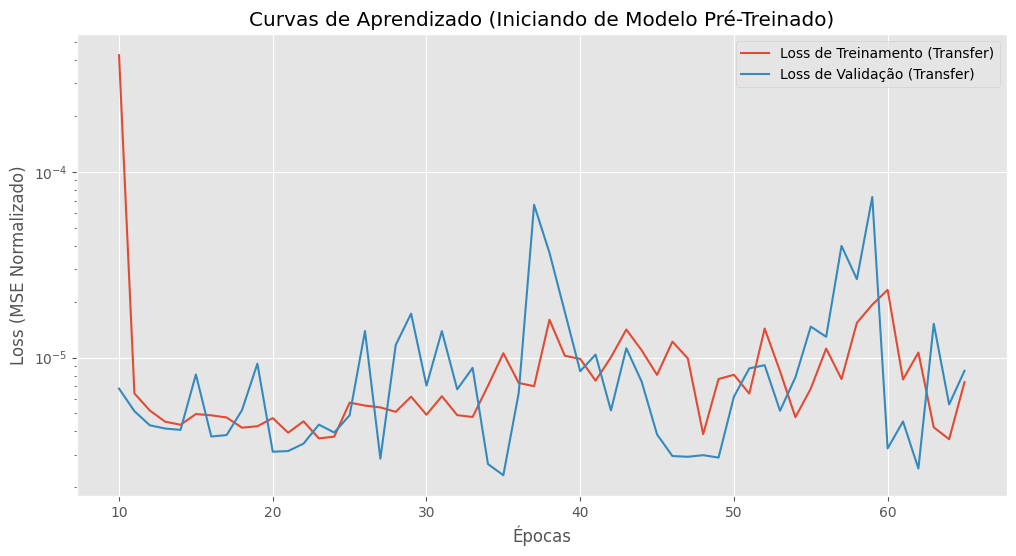

In [39]:
# --- Bloco 7: Gráfico de Treinamento (Loss vs. Epoch) ---
# Este gráfico será a prova: ele vai começar BAIXO.

plt.figure(figsize=(12, 6))
# Plotar o loss a partir da época 11
plt.plot(range(N_EPOCHS_JA_TREINADAS, N_EPOCHS_JA_TREINADAS + len(train_losses)), 
         train_losses, 
         label='Loss de Treinamento (Transfer)')
plt.plot(range(N_EPOCHS_JA_TREINADAS, N_EPOCHS_JA_TREINADAS + len(val_losses)), 
         val_losses, 
         label='Loss de Validação (Transfer)')

plt.title('Curvas de Aprendizado (Iniciando de Modelo Pré-Treinado)')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE Normalizado)')
plt.legend()
plt.yscale('log')
plt.show()

--- Avaliação Final do Modelo de Transferência ---

Métricas Finais (em escala real de R$):
  MSE:  753.16
  RMSE: 27.44
  MAPE: 0.0032 %


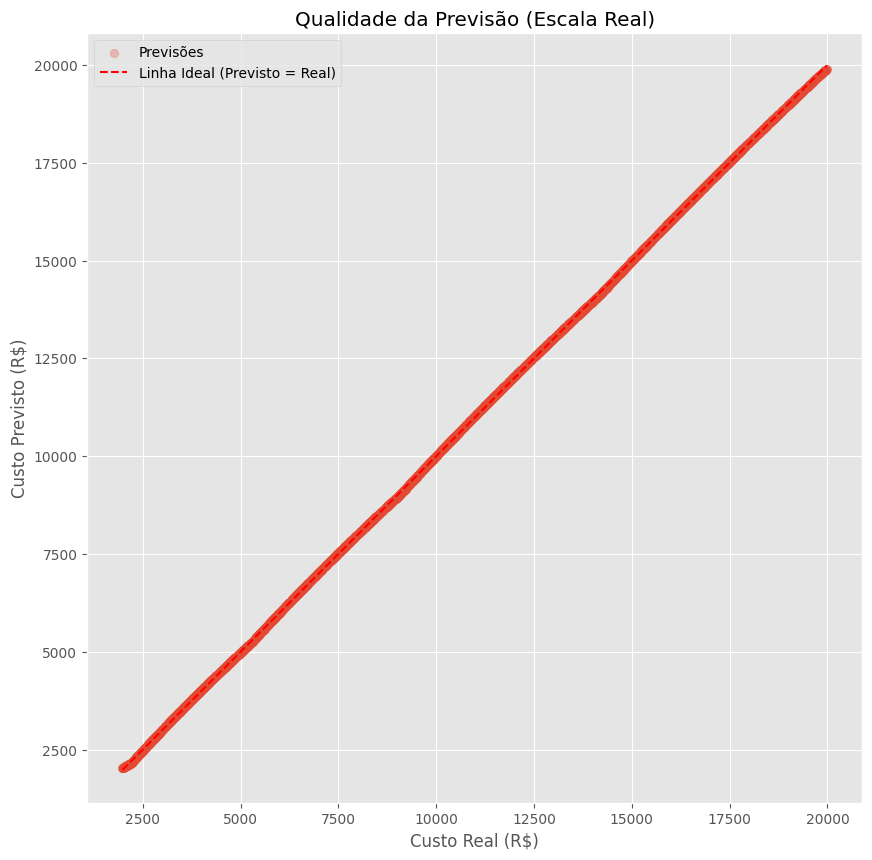

In [40]:
# --- Bloco 8: Avaliação Final (Métricas nos Dados Reais) ---
# Este bloco é idêntico ao Bloco 10 do notebook original,
# apenas carrega o 'transfer_model_final.pth'

print("--- Avaliação Final do Modelo de Transferência ---")

# Carregar os scalers
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')

# Carregar os dados originais (não normalizados)
X = pd.read_csv('usina_carvao_dataset.csv')[['Potencia_MW']].values
y_true_real = pd.read_csv('usina_carvao_dataset.csv')[['Custo_Real']].values

# Carregar o melhor modelo salvo
eval_model = Net(n_layers=BASE_N_LAYERS, n_neurons=BASE_N_NEURONS).to(device)
eval_model.load_state_dict(torch.load('transfer_model_final_limited.pth'))
eval_model.eval()

# Preparar dados de entrada (normalizar)
X_scaled = x_scaler.transform(X)

# Passar TODOS os dados pelo modelo
with torch.no_grad():
    y_pred_scaled_t = eval_model(torch.tensor(X_scaled, dtype=torch.float32).to(device))

# Mover para CPU e converter para NumPy
y_pred_scaled = y_pred_scaled_t.cpu().numpy()

# --- IMPORTANTE: Reverter a Normalização ---
y_pred_real = y_scaler.inverse_transform(y_pred_scaled)

# Calcular métricas finais
mse, rmse, mape = calculate_all_metrics(y_true_real, y_pred_real)

print("\nMétricas Finais (em escala real de R$):")
print(f"  MSE:  {mse:,.2f}")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAPE: {mape:.4f} %")

# --- Gráfico Final: Real vs. Previsto ---
plt.figure(figsize=(10, 10))
plt.scatter(y_true_real, y_pred_real, alpha=0.3, label='Previsões')
# Adicionar a linha ideal (y=x)
ideal_line = np.linspace(min(y_true_real.min(), y_pred_real.min()), 
                         max(y_true_real.max(), y_pred_real.max()), 100)
plt.plot(ideal_line, ideal_line, 'r--', label='Linha Ideal (Previsto = Real)')

plt.title('Qualidade da Previsão (Escala Real)')
plt.xlabel('Custo Real (R$)')
plt.ylabel('Custo Previsto (R$)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Forçar eixos iguais
plt.show()